In [1]:
import matplotlib.pyplot as plt
from graphviz import Digraph
import math
import random

In [2]:
class value: # first we have to inizilize a class which will turn the variable or numbers into an object so that we can do chnages to them
    def __init__(self,data,_children=(),_op="",label=''): #dat= the data,,_op= operation,lable = lable
        self.data = data
        self._op= _op
        self.label = label
        self._prev = set(_children)
        self.grad= 0.0
        self._backprop = lambda :None # here we are initializing a None lambda function so that we can backpropagate from the input to the "How we get to this input " 
        
    def __repr__(self): # returns just the string 
        return f"{self.data}"
    
    def __add__(self,other): #1. taking the self 2. taking the other objects when we initialize
        other = other if isinstance(other,value) else value(other) # used in the situation where the input is object and int like value(30) + 3 so that it turn it into value(int)
        out = value(self.data+other.data,(self,other),"+")
        def _backprop(): # if we do the dy/dx of 2 or more + fucntions w.r.t any one of the variable we get 1 as an output thats why we are multiplying 1 by the previous node of value
            self.grad += 1*out.grad # we're adding it cause sometimes when a variable goes through many functions and output a single function the sum of all the gradients are dependet on the single output 
            other.grad += 1*out.grad
        out._backprop=_backprop
        return out
    
    def __neg__(self):# the "-" symbol has to many meaning and is called neg "negation" it does't actually subtract to make it subtract we'll have to take a clever approach
        return value(-self.data, (self,), "-") # we'll turn it to "-ve " and then use the + - = - method
        
    def __sub__(self,other): # this is where we'll do the subtraction
        other = other if isinstance(other, value) else value(other)
        out = self + (-other)
        
        def _backprop():
            self.grad += 1 * out.grad 
            other.grad += -1 * out.grad
        out._backprop = _backprop
        return out
    
    def __mul__(self,other):
        other = other = other if isinstance(other,value) else value(other) 
        out = value(self.data*other.data,(self,other),"*")
        def _backprop():
            self.grad += other.data*out.grad # when we do the dy/dx of 2 or more variables resultant y and any one of them is dependent variable in that case the other variables are the rate of cahnge of it you can see it by dy/dx of 2x wrt x resultant is: 2 and wrt 2 is : x
            other.grad += self.data*out.grad
        out._backprop=_backprop
        return out 
    
    def __rmul__(self,other):#why we're using the __rmul__ if we have __mul__ becouse rmul give us the functionality in which we can multiply 2*a{a=value(20)} where as we can't do it in mul cause the __mul__function works like a.__mul__(2) but if there is an int in first then it can't send 2.__mul__(20) so thats why
        return self*other
    
    def __pow__(self,other):#now we're defining the power aka pow aka ** function
        assert isinstance(other,(int,float)) #only support in int and float 
        out = value(self.data**other,(self,),f"**{other}")
        def _backprop():#cmon we all know the dy/dx of x**n is n*x**n-1
            self.grad += other*self.data**(other-1)*out.grad
        return out 
    
    def __truediv__(self,other):# to divide we use a clever and a very well known approach which is the "inverse" approach where { a/b == a*(1/b) == a*b**-1}
        other = other if isinstance(other, value) else value(other)
        return self * other ** -1
    
    def tanh(self):
        x = self.data
        exp_x = math.exp(2*x)
        t = (exp_x - 1) / (exp_x + 1)
        out = value(t, (self,), "tanh")
        
        def _backprop():
            self.grad += (1 - t ** 2) * out.grad
        out._backprop = _backprop
        return out
    
    def exp(self):
        x = self.data
        out = value(math.exp(x), (self,), "exp")
        def _backprop():
            self.grad += out.data * out.grad
        out._backprop = _backprop
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1
        for node in reversed(topo):
            node._backprop()
    
    

In [3]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    if isinstance(root, list):
        for v in root:
            build(v)
    else:
        build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s |data %.4f|grad %.4f  }" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [4]:
# right now we're creating a single layer 1 neuron perceptron 
# inputs 
x1=value(2,label="x1")
x2=value(3,label="x2")
#weights
w1=value(0.3,label="w1")
w2=value(4.3,label="w2")
# biase
b = value(4.5233,label="biase")
x1w1= x1*w1;x1w1.label="x1w1"
x2w2= x2*w2;x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label="x1w1+x2w2"
n = x1w1x2w2+b;n.label="n"
k = n.tanh();k.label="k"


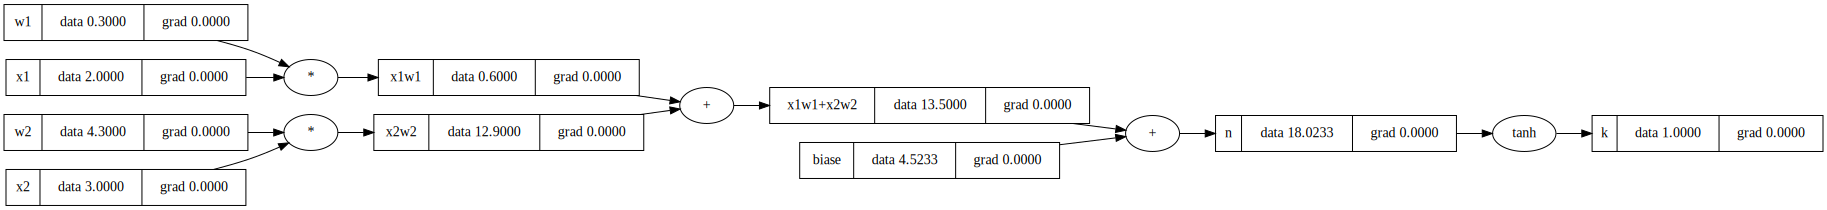

In [5]:
draw_dot(k)

In [6]:
n.backward()

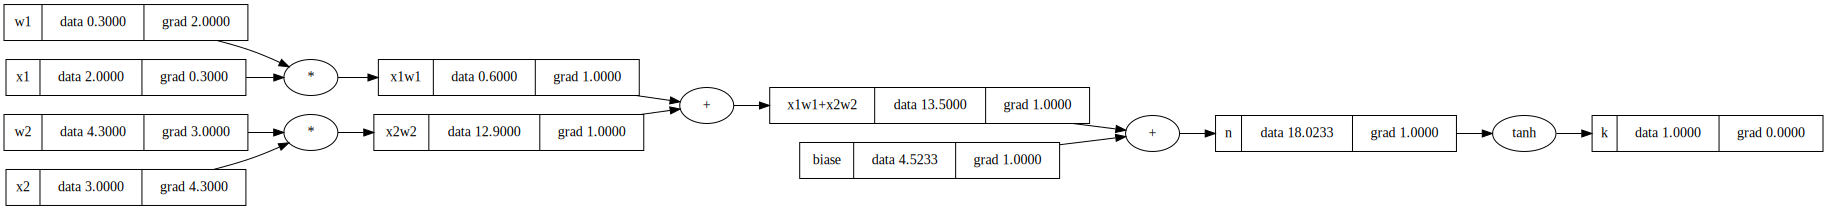

In [7]:
draw_dot(k)

In [8]:
# Now making the making neuron layer and output so that we dont have to do every thing manuaely
#Creating neuron

In [9]:
class neuron:
    def __init__(self, n_input):
        self.w = [value(random.uniform(-1, 1)) for _ in range(n_input)]
        self.b = value(random.uniform(-1, 1))  # Changed to single value
    def __call__(self, x):
        out = sum((xi * wi for xi, wi in list(zip(self.w, x))), self.b)
        out = out.tanh()
        return out 
    def parameter(self):
        return self.w+[self.b]
x = [2.0,3.0]
n = neuron(2)
n(x)

0.9963833238273443

In [10]:
#creating layer
class layer:
    def __init__(self,n_input,n_neuron):
        self.neurons  = [neuron(n_input) for _ in range(n_neuron)]
    def __call__(self,x):
        out = [n(x) for n in self.neurons]
        return out
    def parameter(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameter()
            params.extend(ps)
        return params
n = layer(2,3)
n(x)

[0.975314329313324, -0.9686418481137269, 0.9838105689909515]

In [11]:
#now time to create multi layer perceptron
class MLP:
    def __init__(self,n_input,list_of_n_neuron_each_layers):
        sz = [n_input]+list_of_n_neuron_each_layers
        self.layer = [layer(sz[i],sz[i+1]) for i in range(len(list_of_n_neuron_each_layers))]
    def __call__(self,x):
        for layer in self.layer:
            x= layer(x)
        return x
    def parameter(self):
        params = []
        for layer in self.layer:
            ps = layer.parameter()
            params.extend(ps)
        return params


In [12]:
c= MLP(2,[4,4,1])# in last 1 is for output layer
c(x)

[-0.955076213134823]

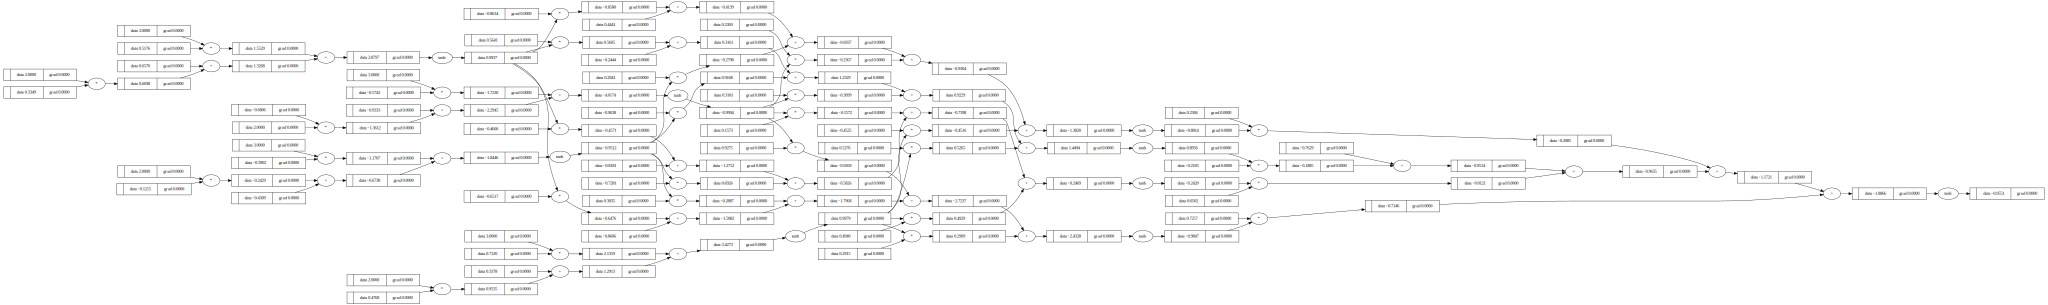

In [13]:
draw_dot(c(x))

In [14]:

# Convert xs and ys to value objects
xs = [[value(1.12), value(3.2), value(0.21)],
      [value(2.1), value(6.2), value(2.1)],
      [value(4.2), value(6.2), value(2.5)]]

ys = [value(-1.0), value(-1.0), value(1.0)]

k = MLP(3, [4, 4, 1])

# Forward pass through the network
outputs = [k(x_) for x_ in xs]
outputs = [out[0] for out in outputs]

# Compute loss (mean squared error)
loss = sum([(pred - real) ** 2 for pred, real in zip(outputs, ys)], value(0))
print(f"Loss: {loss}")

# Backpropagate the loss


Loss: 2.815218639541201


In [15]:
loss.backward()
k.layer[0].neurons[0].w[0].grad

0.0

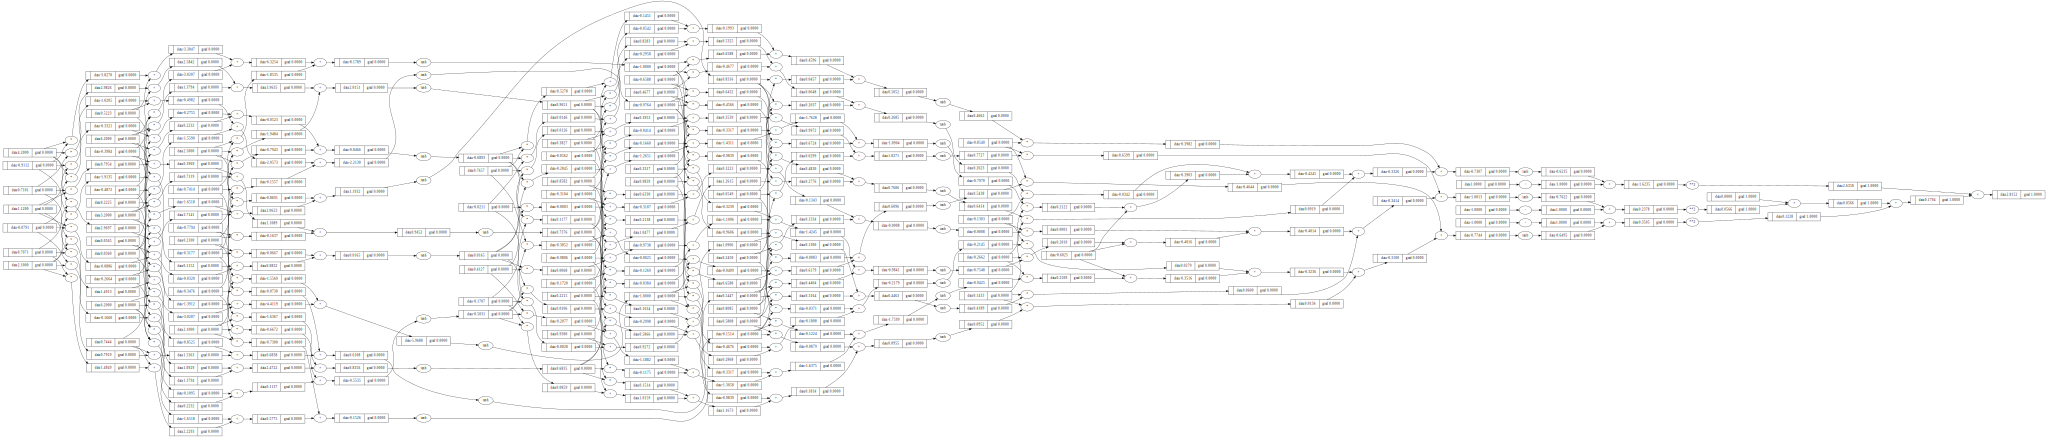

In [16]:
draw_dot(loss)

In [17]:
len(k.parameter())

41

In [18]:
for n in range(100):
    # Forward pass through the network
    outputs = [k(x_) for x_ in xs]
    outputs = [out[0] for out in outputs]

    # Compute loss (mean squared error)
    loss = sum([(pred - real) ** 2 for pred, real in zip(outputs, ys)], value(0))
    loss.backward()
    for p in k.parameter():
        p.grad=0.0
    for p in k.parameter():
        p.data+=-0.05*p.grad
    print(n,loss.data)

0 2.815218639541201
1 2.815218639541201
2 2.815218639541201
3 2.815218639541201
4 2.815218639541201
5 2.815218639541201
6 2.815218639541201
7 2.815218639541201
8 2.815218639541201
9 2.815218639541201
10 2.815218639541201
11 2.815218639541201
12 2.815218639541201
13 2.815218639541201
14 2.815218639541201
15 2.815218639541201
16 2.815218639541201
17 2.815218639541201
18 2.815218639541201
19 2.815218639541201
20 2.815218639541201
21 2.815218639541201
22 2.815218639541201
23 2.815218639541201
24 2.815218639541201
25 2.815218639541201
26 2.815218639541201
27 2.815218639541201
28 2.815218639541201
29 2.815218639541201
30 2.815218639541201
31 2.815218639541201
32 2.815218639541201
33 2.815218639541201
34 2.815218639541201
35 2.815218639541201
36 2.815218639541201
37 2.815218639541201
38 2.815218639541201
39 2.815218639541201
40 2.815218639541201
41 2.815218639541201
42 2.815218639541201
43 2.815218639541201
44 2.815218639541201
45 2.815218639541201
46 2.815218639541201
47 2.815218639541201
48

In [19]:
outputs 

[-0.7621527571405399, -0.6495073516085882, -0.6235153932220441]